In [ ]:
# default_exp train

# train.py

> training model

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
from baseline_3d_pose.utils import *
from baseline_3d_pose.model import *
from baseline_3d_pose.dataset import *
from baseline_3d_pose.viz import *
from fastai.vision import *
from fastprogress.fastprogress import master_bar, progress_bar
import json
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.gridspec import GridSpec

In [ ]:
class Options():
    def __init__(self):
        # paths
        self.data_path = Path('data')
        self.model_path = Path('model')
        
        # train options
        self.actions = 'Eating'
        self.attempt_id = '01'
        self.attempt_path = Path('model')/self.attempt_id
        
        self.load_ckpt = False
        
        # train hyper-params
        self.bs = 64*2
        self.epochs = 10
        self.lr = 1e-3
        
        # model hyper-params
        self.size = 1024
        self.stages = 2
        self.dropout = 0.5
        
        # metrics
        self.train_loss_lists = []
        self.test_loss_lists = []
        self.train_skel_loss_lists = []
        self.test_skel_loss_lists = []

In [ ]:
def save_options(options):
    options.attempt_path.mkdir(exist_ok=True)
    torch.save(options, options.attempt_path/'options.pt')

In [ ]:
def save_ckpt(model_state, optimizer_state, options, is_best=False):
    options.attempt_path.mkdir(exist_ok=True)
    model_name = 'best_model.pt' if is_best else 'last_model.pt'
    optimizer_name = 'best_optimizer.pt' if is_best else 'last_optimizer.pt'
    torch.save(model_state, options.attempt_path/model_name)
    torch.save(optimizer_state, options.attempt_path/optimizer_name)

In [ ]:
options = Options()

In [ ]:
stat_3d = torch.load(data_path/'stat_3d.pt')
stat_2d = torch.load(data_path/'stat_2d.pt')
rcams = torch.load(data_path/'rcams.pt')

mean_2d = stat_2d['mean']
std_2d = stat_2d['std']
dim_use_2d = stat_2d['dim_use']
dim_ignore_2d = stat_2d['dim_ignore']

mean_3d = stat_3d['mean']
std_3d = stat_3d['std']
dim_use_3d = stat_3d['dim_use']
dim_ignore_3d = stat_3d['dim_ignore']

In [ ]:
device = torch.device('cuda')

In [ ]:
def train(train_dl, model, criterion, optimizer, options, mb):
    model.train()
    loss_list = []
    skel_loss_list = []
    for xb, yb in progress_bar(train_dl, parent=mb):
        xb, yb = xb.cuda(), yb.cuda()
        yhat = model(xb)
        optimizer.zero_grad()
        loss_skel = criterion(yhat, yb)
        loss = loss_skel.mean()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        loss_list.append(loss.item())
        skel_loss_list.append(loss_skel.data.cpu().numpy())
        
        mb.child.comment = f'train loss: {loss.item()}'
    return loss_list, skel_loss_list

In [ ]:
def test(test_dl, model, criterion, options, mb):
    model.eval()
    loss_list = []
    skel_loss_list = []
    for xb, yb in progress_bar(train_dl, parent=mb):
        xb, yb = xb.cuda(), yb.cuda()
        with torch.no_grad():
            yhat = model(xb)
            loss_skel = criterion(yhat, yb)
            loss = loss_skel.mean()
        loss_list.append(loss.item())
        skel_loss_list.append(loss_skel.data.cpu().numpy())
        mb.child.comment = f'test loss: {loss.item()}'
    return loss_list, skel_loss_list

In [ ]:
model = Model()
model = model.cuda()
model.apply(init_kaiming)
print(f'total params: {sum(p.numel() for p in model.parameters())}')

criterion = nn.MSELoss(reduction='none').cuda()
optimizer = optim.Adam(model.parameters(), lr=options.lr)

if options.load_ckpt:
    options = torch.load('model/01/options.pt')
    model_state = torch.load(options.attempt_path/'last_model.pt')
    optimizer_state = torch.load(options.attempt_path/'last_optimizer.pt')
    model.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_state)

train_ds = Human36Dataset(get_actions(options.actions), options.data_path, is_train=True)
train_dl = DataLoader(train_ds, batch_size=options.bs, shuffle=True)
test_ds = Human36Dataset(get_actions(options.actions), options.data_path, is_train=False)
test_dl = DataLoader(train_ds, batch_size=options.bs, shuffle=False)

mb = master_bar(range(0, 2))
for epoch in mb:
    train_loss_list, train_skel_loss_list = train(train_dl, model, criterion, optimizer, options, mb)
    options.train_loss_lists.append(train_loss_list)
    options.train_skel_loss_lists.append(train_skel_loss_list)
    
    test_loss_list, test_skel_loss_list = test(test_dl, model, criterion, options, mb)
    options.test_loss_lists.append(test_loss_list)
    options.test_skel_loss_lists.append(test_skel_loss_list)
    
    mb.main_bar.comment = f'train loss_mean: {np.mean(train_loss_list)} | test loss_mean: {np.mean(test_loss_list)}'

total params: 4291632


In [ ]:
train_loss = np.hstack((options.train_loss_lists[0], options.train_loss_lists[1]))
test_loss = np.hstack((options.test_loss_lists[0], options.test_loss_lists[1]))

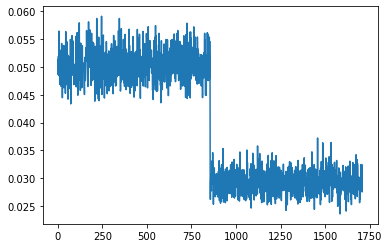

In [ ]:
plt.plot(test_loss)

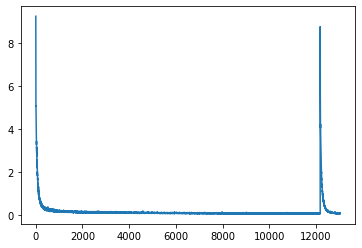

In [ ]:
plt.plot(train_loss)